
## Medical Image Segementation Using Pytorch

In [0]:
### Importing Library

%matplotlib inline
import os
import re
import numpy as np
import random
import tarfile
import urllib
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split



In [0]:
##### make directories in Colab

!mkdir -p sample_testdata
!mkdir -p sample_testdata/train
!mkdir -p sample_testdata/test/
!mkdir -p sample_testdata/train/mask
!mkdir -p sample_testdata/train/image
!mkdir -p sample_testdata/test/image

In [0]:
##### make directories in Colab
!rm -rf train

!mkdir -p train/image
!mkdir -p train/mask
!mkdir -p test/image
!mkdir -p test/mask
## direct input from google drive
url="https://drive.google.com/file/d/1jncfX2ov-k4tsM-2cPUnGRWiZvD7qXCK/view?usp=sharing"


In [0]:
### download package if not installed 
### !pip3 install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1jncfX2ov-k4tsM-2cPUnGRWiZvD7qXCK',
                                    dest_path='/content/sample_dataset_for_testing.tar.gz',
                                    unzip=True)


Unzipping...

/usr/local/lib/python3.6/dist-packages/google_drive_downloader/google_drive_downloader.py:73: UserWarning: Ignoring `unzip` since "1jncfX2ov-k4tsM-2cPUnGRWiZvD7qXCK" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [0]:
##Extract the tar file using tarfile package
## inatll the package uisng command
###!pip3 install tarfile
import tarfile
tf = tarfile.open("/content/sample_dataset_for_testing.tar.gz", mode='r:gz')
tf.extractall()

In [0]:

# Some constants 
INPUT_FOLDER = '/content/sample_dataset_for_testing/fullsampledata/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
## remove file to clear disk space
!rm -rf sample_dataset_for_testing.tar.gz

In [0]:
slices = []
lis2=[]
lis3=[]
lis4=[]
patients=[]
dirname = INPUT_FOLDER
final = []
for dirnam in os.listdir(dirname):
  for d2name in os.listdir(dirname+ '/' +dirnam):
    
    for fname in os.listdir(dirname+ '/' +dirnam+ '/' +d2name):
      lis2.append(fname)
      lis3.append(dirname+ '/' +dirnam+ '/' +d2name+'/'+fname)
      lis4.append(dirname+ '/' +dirnam+ '/' +d2name+'/')
      patients.append(d2name)

In [0]:

df=pd.DataFrame({'image':lis2, 'location':lis3, 'patients': patients, 'imgf':lis4})
df.head()
df4=df[df['image'].str.contains('_mask')==False]
df3=df[df['image'].str.contains('_mask')==True]


df3['has_mask']=1
df4['has_mask']=0
df3[['image_o','dis']] = df3.image.str.split("_",expand=True,)
df3['dis']=df3['image_o'].astype(str) + '.tiff'

In [0]:

#suffle the data


images=df3['dis'].tolist()
mask=df3['image'].tolist()
image=[]
masks=[]
abnormal_train = df3['imgf'].tolist()
p=[i.split('_', 1)[0] for i in images]
print(p[1])
normal_train = df3['imgf'].tolist()
count_file=0
import os 
destination='/content/train/image/'
for al in range(0,55):
    destination='/content/train/image/'
    src=abnormal_train[al]+images[al]
    
    if not os.path.exists(src)==False:
        shutil.copy(src,destination)
        image.append(images[al])
        print('os')
    else:
        count_file=count_file+1
        destination='/content/train/image/'+str(count_file)+'.tiff'
        shutil.copy(src,destination)
        image.append(str(count_file)+'.tiff')
    src=normal_train[al]+mask[al]
    destination='/content/train/mask/'
    if not os.path.exists(src)==False:
        shutil.copy(src,destination)
        masks.append(mask[al])
    else:
        count_file=count_file+1
        destination='/content/train/mask/'+str(count_file)+'_mask.tiff'
        shutil.copy(src,destination)
        masks.append(str(count_file)+'_mask.tiff')
    count_file+=1
for al in range(55,62):
    destination='/content/test/image/'
    src=abnormal_train[al]+images[al]
    
    if not os.path.exists(src)==False:
        shutil.copy(src,destination)
        image.append(images[al])
        print('os')
    else:
        count_file=count_file+1
        destination='/content/test/image/'+str(count_file)+'.tiff'
        shutil.copy(src,destination)
        image.append(str(count_file)+'.tiff')
    src=normal_train[al]+mask[al]
    destination='/content/test/mask/'
    if not os.path.exists(src)==False:
        shutil.copy(src,destination)
        masks.append(mask[al])
    else:
        count_file=count_file+1
        destination='/content/test/mask/'+str(count_file)+'_mask.tiff'
        shutil.copy(src,destination)
        masks.append(str(count_file)+'_mask.tiff')
    count_file+=1
        

In [0]:
    
### defining class to import data
class lungDataset(Dataset):
  def __init__(self, root_dir, transform=None, target_transform=None, download=False):
        """
        Args:
            root_dir (string): Data directory containing the fish_image and mask_image folders.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        
        self.root_dir = os.path.abspath(root_dir)
        self.transform = transform
        self.target_transform = target_transform


        self.images = glob('/content/train/image/*')
        self.masks = glob('/content/train/image/*')
        self.labels=[int(re.search('/*image/(\d+)*', image).group(1)) for image in self.images]
    
  def __len__(self):
        return len(self.labels)
  def __getitem__(self, index):
        label = self.labels[index]
        image = Image.open(self.images[index])
        mask = Image.open(self.masks[index])

        if mask.mode == '1':
            mask = mask.convert('L')

        
        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform is not None:
            image = self.transform(image)

        random.seed(seed)
        if self.target_transform is not None:
            mask = self.target_transform(mask)
            mask = mask.round()

        return (image, mask, label)
 




In [0]:

### Convolution block

class conv_block(nn.Module):
    def __init__(self, in_channels,  out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        init.xavier_uniform(self.conv.weight, gain=np.sqrt(2))
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x

### using unet model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(
            conv_block(1, 32),
            conv_block(32, 32)
        )
        self.down2 = nn.Sequential(
            conv_block(32, 64),
            conv_block(64, 64)
        )
        self.down3 = nn.Sequential(
            conv_block(64, 128),
            conv_block(128, 128)
        )

        self.middle = conv_block(128, 128)

        self.up3 = nn.Sequential(
            conv_block(256, 256),
            conv_block(256, 64)
        )

        self.up2 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 32)
        )

        self.up1 = nn.Sequential(
            conv_block(64, 64),
            conv_block(64, 1)
        )

    def forward(self,  x):
        
        down1 = self.down1(x)
        out = F.max_pool2d(down1, 2)

        down2 = self.down2(out)
        out = F.max_pool2d(down2, 2)

        down3 = self.down3(out)
        out = F.max_pool2d(down3, 2)

        out = self.middle(out)

        out = F.interpolate(out, scale_factor=2)
        out = torch.cat([down3, out], 1)
        out = self.up3(out)

        out = F.interpolate(out, scale_factor=2)
        out = torch.cat([down2, out], 1)
        out = self.up2(out)

        out = F.interpolate(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up1(out)

        out = torch.sigmoid(out)

        return out

In [0]:

### transform data 
train_transform = transforms.Compose([

    transforms.ToTensor()
])

test_transform = transforms.Compose([
    
    transforms.ToTensor()
])

In [0]:
## loading data to pytorch
train_dataset = lungDataset('/content/train', transform=train_transform, target_transform=train_transform)
valid_dataset=lungDataset('/content/test', transform=train_transform, target_transform=train_transform)
len(train_dataset)

43

In [4]:
## loading data to pytorch
batch_size=4
num_workers=1

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers
    )
valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size,
        num_workers=num_workers
    )


NameError: ignored

In [0]:
### ceating jaccard index
def jaccard(outputs, targets):
    outputs = outputs.view(outputs.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (outputs * targets).sum(1)
    union = (outputs + targets).sum(1) - intersection
    jac = (intersection + 0.001) / (union + 0.001)
    return jac.mean()

In [0]:

## model object
model = UNet()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()


In [0]:
## defining optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [0]:
## mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## saving model
model_folder = os.path.abspath('/content/gdrive/My Drive/')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model_path = os.path.join(model_folder, 'unet.pt')

In [0]:
###Training and testing model

hist = {'loss': [], 'jaccard': [], 'val_loss': [], 'val_jaccard': []}
num_epochs = 10
display_steps = 20
best_jaccard = 0
for epoch in range(num_epochs):
    print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
    # train
    model.train()
    running_loss = 0.0
    running_jaccard = 0.0
    for batch_idx,(images, masks, _) in enumerate(train_loader):
        images = images
        masks = masks
        
        optimizer.zero_grad()
        images.unsqueeze(0)
        outputs = model(images)
        predicted = outputs.round()
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        jac = jaccard(outputs.round(), masks)
        running_jaccard += jac.data
        running_loss += loss.data
        
        if batch_idx % display_steps == 0:
            print('    ', end='')
            print('batch {:>3}/{:>3} loss: {:.4f}, jaccard {:.4f}\r'\
                  .format(batch_idx+1, len(train_loader),
                          loss.data, jac.data))

        
    # evalute
    print('Finished epoch {}, starting evaluation'.format(epoch+1))
    model.eval()
    val_running_loss = 0.0
    val_running_jaccard = 0.0
    for images, masks, _ in valid_loader:
        images = images
        masks = masks
        outputs.unsqueeze(0)
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        val_running_loss += loss.data
        jac = jaccard(outputs.round(), masks)
        val_running_jaccard += jac.data

    train_loss = running_loss / len(train_loader)
    train_jaccard = running_jaccard / len(train_loader)
    val_loss = val_running_loss / len(valid_loader)
    val_jaccard = val_running_jaccard / len(valid_loader)
    
    hist['loss'].append(train_loss)
    hist['jaccard'].append(train_jaccard)
    hist['val_loss'].append(val_loss)
    hist['val_jaccard'].append(val_jaccard)
    
    if val_jaccard > best_jaccard:
        torch.save(model, model_path)
    print('    ', end='')
    print('loss: {:.4f}  jaccard: {:.4f} \
           val_loss: {:.4f} val_jaccard: {:4.4f}\n'\
           .format(train_loss, train_jaccard, val_loss, val_jaccard))

Starting epoch 1/10
    batch   1/ 11 loss: 238.4314, jaccard 0.7477
Finished epoch 1, starting evaluation
    loss: -19.2045  jaccard: 0.0712            val_loss: -63.0340 val_jaccard: 0.0218

Starting epoch 2/10


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type conv_block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


    batch   1/ 11 loss: -60.0687, jaccard -0.0245
Finished epoch 2, starting evaluation
    loss: -61.1771  jaccard: -0.0209            val_loss: -67.9348 val_jaccard: -0.0077

Starting epoch 3/10
    batch   1/ 11 loss: -68.7101, jaccard -0.0280
Finished epoch 3, starting evaluation
    loss: -66.4457  jaccard: -0.0262            val_loss: -51.1623 val_jaccard: -0.0250

Starting epoch 4/10
    batch   1/ 11 loss: -71.9692, jaccard -0.0304
Finished epoch 4, starting evaluation
    loss: -69.4874  jaccard: -0.0277            val_loss: -56.7596 val_jaccard: -0.0289

Starting epoch 5/10
    batch   1/ 11 loss: -73.5761, jaccard -0.0313
Finished epoch 5, starting evaluation
    loss: -71.6802  jaccard: -0.0283            val_loss: -62.2408 val_jaccard: -0.0304

Starting epoch 6/10
    batch   1/ 11 loss: -75.4046, jaccard -0.0323
Finished epoch 6, starting evaluation
    loss: -73.6016  jaccard: -0.0293            val_loss: -65.3938 val_jaccard: -0.0310

Starting epoch 7/10
    batch   1/ 

In [0]:
## laoding model from drive
model_save_name = 'unet.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.load(path)

UNet(
  (down1): Sequential(
    (0): conv_block(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
    (1): conv_block(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (down2): Sequential(
    (0): conv_block(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
    (1): conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [0]:
### visualizing- evaluation:
def extract_lungs(image, model):
    original_shape = image.size
    image = image.resize((128, 128))
    inputs = transforms.ToTensor()(image).unsqueeze(0)
    outputs = model(inputs).round().squeeze(0).cpu().data
    mask = transforms.ToPILImage()(outputs)
    background = Image.new('RGB', (128, 128), color='white')
    
    return Image.composite(image, background, mask).resize(original_shape)

In [0]:
images = [valid[i][0] for i in test_indices[:10]]

In [0]:
#train_dataset = lungDataset('/content/train')
eval_dataset=lungDataset('/content/test')

images = [eval_dataset[i][0] for i in range(len(eval_dataset))]


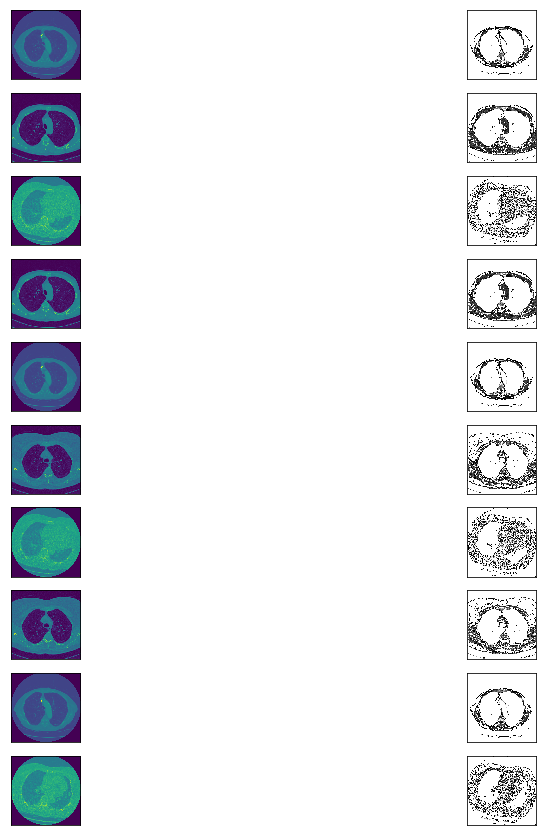

In [0]:
fig, axis = plt.subplots(10, 2, figsize=(15,15))
for image, (ax1, ax2) in zip(images, axis):
    fish = extract_fish(image, model)
    ax1.imshow(image)
    ax2.imshow(fish)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
plt.show()

Model is not robust because of its not fined tuned and hyperparameters are not tested on. 
There is much scope for improvement. 